In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
x = pd.read_csv('parkinsons_updrs.csv')
features = x.columns  # first columns will contain the names of the features
print(f'Dataset size = {x.shape}')
print(f'Dataset features count = {len(features)}')
# print(features)

Dataset size = (5875, 22)
Dataset features count = 22


<font size=6>Features list:</font>
- **subject#**: patient number
- **age**: age of the patient
- **sex**: sex of the patient
- **test_time**: period from the beginning of the measurement (integer -> day, float -> hour from 0AM to 12PM)
- **motor_UPDRS**:
- **total_UPDRS**:
*Jitter*, in general, is the variation of the fundamental frequency in signals that should be periodic but are not
- **Jitter(%)**, **Jitter(Abs)**, **Jitter:RAP**, **Jitter:PPQ5**, **Jitter:DDP**
*Shimmer*, in general, is the variation of amplitude in signals that should be periodic but are not
- **Shimmer**, **Shimmer(dB)**, **Shimmer:APQ3**, **Shimmer:APQ5**, **Shipper:APQ11**, **Shimmer:DDA**
- **NHR**: Noise to Harmonics Ratio
- **HNR**: Harmonic to Noise Ratio
- **RPDE**: Recurrence Period Density Entropy
- **DFA**: Detrended Fluctuation Analysis
- **PPE**: Perceived Vocal Effort is the measure of effort (physical and cognitive) used to produce speech

In [43]:
X = pd.DataFrame()
subj = np.unique(x['subject#'])
for k in subj:  # for each subject#
    xk = x[x['subject#'] == k]
    xk1 = xk.copy()
    xk1.test_time = xk1.test_time.astype(int)
    xk1['g'] = xk1['test_time']  # new property called 'g' containing the 'test_time' property
    # now the dataframe collapses using 'g' as pivot, and computing the mean for each other property
    v = xk1.groupby('g').mean()
    X = pd.concat([X, v], axis=0, ignore_index=True)  # axis=0 -> concatenation along rows. (0, 1) -> (rows, columns)
features = x.columns
Np, Nc = X.shape
print(f'X shape = {X.shape}')

X shape = (990, 22)


In [44]:
Xnorm = (X - X.mean()) / X.std()
c = Xnorm.cov()

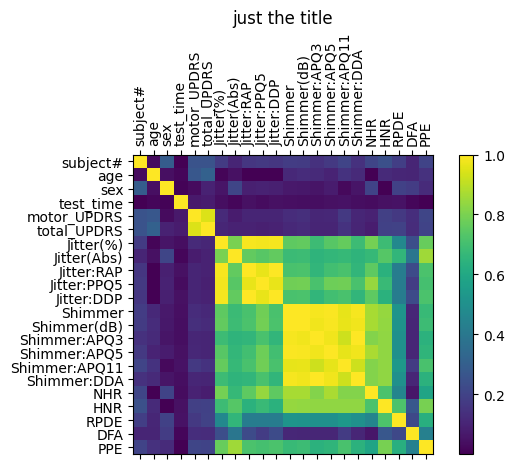

In [45]:
plt.figure()
plt.matshow(np.abs(c.values), fignum=0)
plt.xticks(np.arange(len(features)), features, rotation=90)
plt.yticks(np.arange(len(features)), features, rotation=0)
plt.colorbar()
plt.title('just the title')
plt.tight_layout()
plt.savefig('./corr_coeff.png')
plt.show()

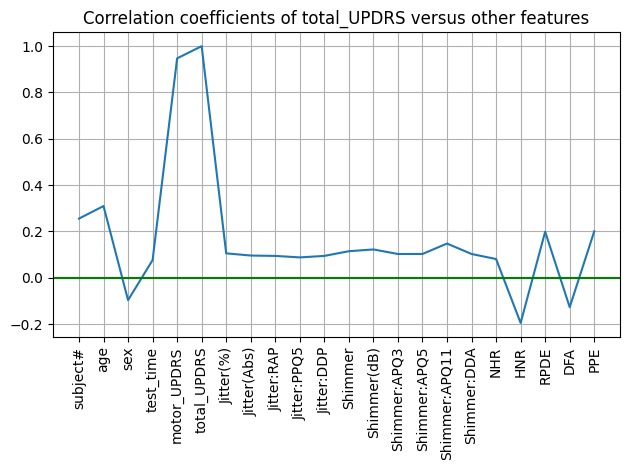

In [46]:
plt.figure()
c.total_UPDRS.plot()
plt.grid()
plt.xticks(np.arange(len(features)), features, rotation=90)
plt.axhline(y=0, color='g')
plt.title('Correlation coefficients of total_UPDRS versus other features')
plt.tight_layout()
plt.show()

In [47]:
# seed = 319244
# Xsh = X.sample(frac=1, replace=False, random_state=seed, axis=0, ignore_index=True)
Xsh = X.sample(frac=1, replace=False, axis=0, ignore_index=True)

<font size=6>Dataset splitting</font>
**Training set**: 50%
**Validation set**: 25%
**Test set**: 25%

In [49]:
# Percentages
percent_training = 0.5
percent_test = 0.25
percent_validation = 1 - percent_training - percent_test

In [50]:
Ntr = int(Np * percent_training)  # Number of training points
Nte = int(Np * percent_test)  # Number of test points
Nva = Np - Ntr - Nte

X_tr = Xsh[:Ntr]

mm = X_tr.mean()
ss = X_tr.std()
my = mm['total_UPDRS']
sy = ss['total_UPDRS']
mm_vals = mm.values
ss_vals = ss.values

In [51]:
Xsh_norm = (Xsh - mm_vals) / ss_vals  # normalization of all parameters
ysh_norm = Xsh_norm['total_UPDRS']  # total_UPDRS will be the regressand
Xsh_norm = Xsh_norm[['motor_UPDRS', 'age', 'PPE']]  # keeping only these three regressors
# Xsh_norm = Xsh_norm.drop(['total_UPDRS', 'subject#', 'test_time'], axis=1)  # removing the regressand and other useless
# or known correlated features

X_tr_norm = Xsh_norm[:Ntr].values
X_va_norm = Xsh_norm[Ntr:Ntr + Nva].values
X_te_norm = Xsh_norm[-Nte:].values
y_tr_norm = ysh_norm[:Ntr].values
y_va_norm = ysh_norm[Ntr:Ntr + Nva].values
y_te_norm = ysh_norm[-Nte:].values

In [52]:
# Useful functions
def eucl_distance(v1, v2):
    assert len(v1) == len(v2)
    v_diff = v1 - v2
    return np.sqrt(v_diff.T @ v_diff)


def e_MSE(y, y_hat):
    assert len(y) == len(y_hat)
    Ndataset = len(y)
    return sum((y[i] - y_hat[i]) ** 2 for i in range(Ndataset)) / Ndataset


def GPR(X_tr, y_tr, X_te, t, r2, s2, N):
    Ntr = len(X_tr)
    Nte = len(X_te)
    y_hat = np.empty(Nte)
    variance = np.empty(Nte)
    for row in range(Nte):
        x = X_te[row]
        distances = [eucl_distance(x, X_tr[i]) for i in range(Ntr)]
        i_order = np.argsort(distances)
        closer_X = np.array([X_tr[i] for i in i_order[:N - 1]])
        closer_y = np.array([y_tr[i] for i in i_order[:N - 1]])
        Xr = np.concatenate((closer_X, [x]), axis=0)
        Rn = np.empty(shape=(N, N))
        for n in range(N):
            for k in range(N):
                Rn[n, k] = t * np.exp(- (np.linalg.norm(Xr[n] - Xr[k]) ** 2) / (2 * r2))
                if n == k:
                    Rn[n, k] = Rn[n, k] + s2 ** 2
        k = Rn[-1, :-1]
        d = Rn[-1, -1]
        Rn_sub_inv = np.linalg.inv(Rn[:-1, :-1])
        y_hat[row] = k.T @ Rn_sub_inv @ closer_y
        variance[row] = d - k.T @ Rn_sub_inv @ k
    return {'expected': y_hat, 'variance': variance}

In [53]:
# Solver's initial hyperparameters
t = 1
r2 = 100
s2 = 0.001
N = 10

In [54]:
y_va_hat_norm = GPR(X_tr=X_tr_norm, y_tr=y_tr_norm, X_te=X_va_norm,
                    t=t, r2=r2, s2=s2, N=N)['expected']
MSE_va = e_MSE(y_va_norm, y_va_hat_norm)
print(f'MSE for the validation set: {MSE_va}')
print('Hyperparameters used:')
print(f't = {t}')
print(f'r2 = {r2}')
print(f's2 = {s2}')
print(f'N = {N}')

MSE for the validation set: 0.04927986525777656
Hyperparameters used:
t = 1
r2 = 100
s2 = 0.001
N = 10


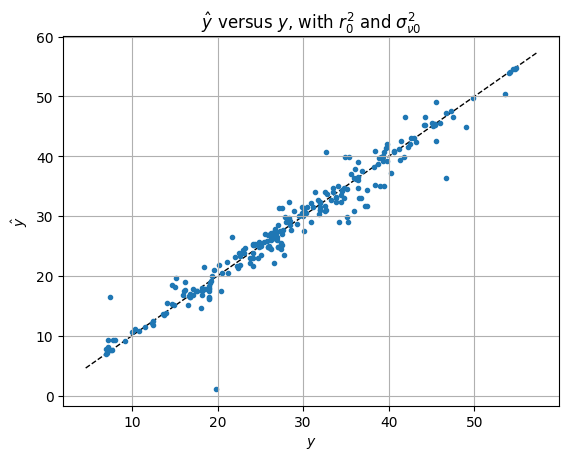

In [55]:
y_hat = y_va_hat_norm * sy + my
y_va = y_va_norm * sy + my
plt.figure()
plt.plot(y_va, y_hat, '.', zorder=1)
v = plt.axis()
plt.plot([v[0], v[1]], [v[0], v[1]], 'k--', linewidth=1, zorder=0)
plt.xlabel(r'$y$')
plt.ylabel(r'$\^y$')
plt.title('$\^y$ versus $y$, with $r_0^2$ and $\\sigma_{\\nu 0}^2$')
plt.grid()
plt.show()

<font size="6">Grid search section</font>
Two sets, one for $r^2$ and one for $\sigma^2$, are created, then the *GPR* is computed for each combination of values $r^2$ and $\sigma^2$. The values $r_{best}^2$ and $\sigma_{best}^2$ are initialized with current $r^2$ and $\sigma^2$ values, and are updated during the search if an *MSE* computed is lesser than the current smallest value.

In [56]:
# Setting best r2 and s2; they will be updated during the grid search
r2_best = r2
s2_best = s2

# Setting the number of values that will be used for the grid search
Nr2 = 20
Ns2 = 20

# Generating equally spaced values for r2 and s2
r2_range = np.linspace(1, 100, Nr2)
s2_range = np.linspace(1e-5, 1e-1, Ns2)

MSE_r2s2_best = MSE_va  # Setting the error for the current r2 and s2 values
for i_r2 in range(Nr2):
    for j_s2 in range(Nr2):
        y_va_hat_norm = GPR(X_tr=X_tr_norm, y_tr=y_tr_norm, X_te=X_va_norm,
                            t=t, r2=r2_range[i_r2], s2=s2_range[j_s2], N=N)['expected']
        MSE_r2s2 = e_MSE(y_va_norm, y_va_hat_norm)
        # Updating r2 and s2 values if the current set of r2 and s2 is better (in MSE sense)
        if MSE_r2s2 < MSE_r2s2_best:
            MSE_r2s2_best = MSE_r2s2
            r2_best = r2_range[i_r2]
            s2_best = s2_range[j_s2]

In [57]:
# Result with best r2 and s2
y_hat_norm_r2s2 = GPR(X_tr=X_tr_norm, y_tr=y_tr_norm, X_te=X_va_norm,
                      t=t, r2=r2_best, s2=s2_best, N=N)['expected']
print('Grid search results:')
print(f'MSE = {MSE_r2s2_best}')
print(f'r2 = {r2_best}')
print(f's2 = {s2_best}')

Grid search results:
MSE = 0.03954427612745573
r2 = 6.2105263157894735
s2 = 0.06842421052631578


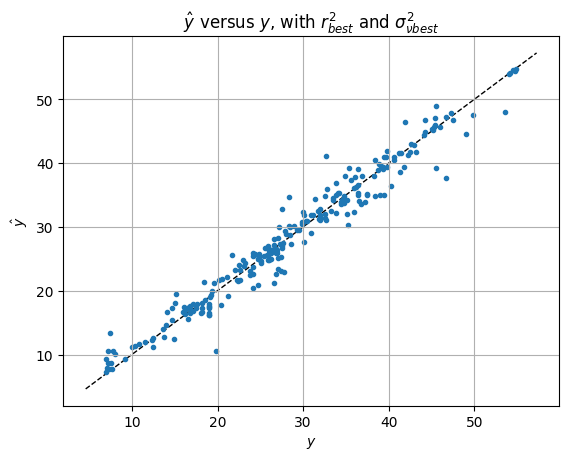

In [58]:
y_va_hat = y_hat_norm_r2s2 * sy + my
y_va = y_va_norm * sy + my
plt.figure()
plt.plot(y_va, y_va_hat, '.', zorder=1)
v = plt.axis()
plt.plot([v[0], v[1]], [v[0], v[1]], 'k--', linewidth=1, zorder=0)
plt.xlabel(r'$y$')
plt.ylabel(r'$\^y$')
plt.title('$\^y$ versus $y$, with $r_{best}^2$ and $\\sigma_{\\nu best}^2$')
plt.grid()
plt.show()

<font size=6>Computing results with different values for N</font>
Just like the *grid search*, a set of values for $N$ is generated. Each value is tested and $N_{best}$ is updated when the computed *MSE* is lesser than the current $N_{best}$

In [59]:
N_best = N  # Setting initial best N; it will be updated during the testing
N_values = np.arange(2, 50, dtype=int)  # Setting the values of N that will be tested
MSE_best = MSE_r2s2_best  # Setting the error for the current r2 and s2 values
for i in range(len(N_values)):
    y_hat_norm_N = GPR(X_tr=X_tr_norm, y_tr=y_tr_norm, X_te=X_va_norm,
                       t=t, r2=r2_best, s2=s2_best, N=N)['expected']
    MSE_N = e_MSE(y_va_norm, y_hat_norm_N)
    # Updating N value if the current N is better (in MSE sense)
    if MSE_N < MSE_best:
        MSE_best = MSE_N
        N_best = N

In [60]:
# Result with best N (with r2 and s2 previous computed)
y_hat_norm_best = GPR(X_tr=X_tr_norm, y_tr=y_tr_norm, X_te=X_va_norm,
                      t=t, r2=r2_best, s2=s2_best, N=N_best)['expected']
print('N values testing results:')
print(f'MSE = {MSE_best}')
print(f'N = {N_best}')

N values testing results:
MSE = 0.03954427612745573
N = 10


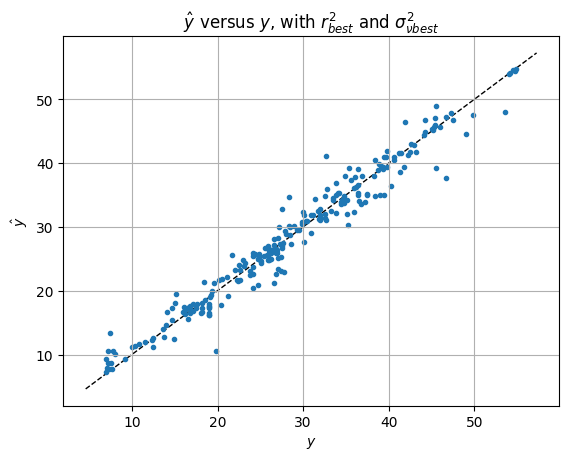

In [61]:
y_va_hat = y_hat_norm_best * sy + my
y_va = y_va_norm * sy + my
plt.figure()
plt.plot(y_va, y_va_hat, '.', zorder=1)
v = plt.axis()
plt.plot([v[0], v[1]], [v[0], v[1]], 'k--', linewidth=1, zorder=0)
plt.xlabel(r'$y$')
plt.ylabel(r'$\^y$')
plt.title('$\^y$ versus $y$, with $r_{best}^2$ and $\\sigma_{\\nu best}^2$')
plt.grid()
plt.show()

<font size=6>Test section</font>
Now the *GPR* is used to predict values for the *test set*

In [62]:
print(f'r2 = {r2_best}')
print(f's2 = {s2_best}')
print(f'N = {N_best}')

# GPR results
GPR_va = GPR(X_tr=X_tr_norm, y_tr=y_tr_norm, X_te=X_va_norm,
             t=t, r2=r2_best, s2=s2_best, N=N_best)
GPR_te = GPR(X_tr=X_tr_norm, y_tr=y_tr_norm, X_te=X_te_norm,
             t=t, r2=r2_best, s2=s2_best, N=N_best)

# De-normalization
y_va_hat = GPR_va['expected'] * sy + my
y_va = y_va_norm * sy + my

y_te_hat = GPR_te['expected'] * sy + my
y_te = y_te_norm * sy + my

r2 = 6.2105263157894735
s2 = 0.06842421052631578
N = 10


In [63]:
# Validation set measurements
mean_va = np.mean(y_va_hat, axis=0)
var_va = np.var(y_va_hat, axis=0)
std_va = np.std(y_va_hat, axis=0)
MSE_va = e_MSE(y_va, y_va_hat)
corr_coeff_va = np.mean((y_va - mean_va) * (y_va_hat - y_va_hat.mean())) / (y_va.std() * y_va_hat.std())
R2_va = 1 - MSE_va / var_va

In [64]:
# Test set measurements
mean_te = np.mean(y_te_hat, axis=0)
var_te = np.var(y_te_hat, axis=0)
std_te = np.std(y_te_hat, axis=0)
MSE_te = e_MSE(y_te, y_te_hat)
corr_coeff_te = np.mean((y_te - mean_te) * (y_te_hat - y_te_hat.mean())) / (y_te.std() * y_te_hat.std())
R2_te = 1 - MSE_te / var_te

In [65]:
# Preparing result dataset
rows = ['Validation', 'Test']
cols = ['mean', 'std', 'MSE', 'correlation coefficient', 'R^2']
p = np.array([
    [mean_va, std_va, MSE_va, corr_coeff_va, R2_va],
    [mean_te, std_te, MSE_te, corr_coeff_te, R2_te]
])
results = pd.DataFrame(p, columns=cols, index=rows)
print(results)

                 mean        std       MSE  correlation coefficient       R^2
Validation  28.486829  10.577173  4.660633                 0.979663  0.958341
Test        28.479278  10.137180  4.625145                 0.977963  0.954992


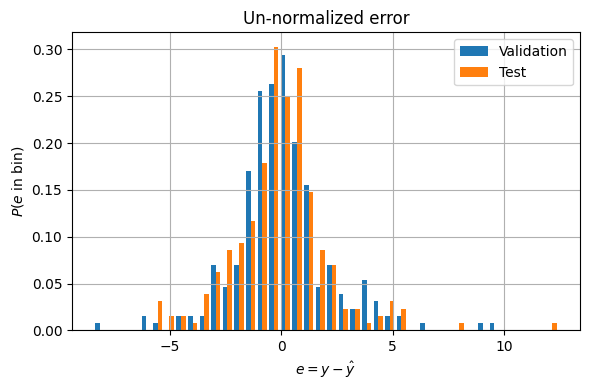

In [66]:
# Histogram of the un-normalized error
err_va = y_va - y_va_hat
err_te = y_te - y_te_hat
e = [err_va, err_te]
plt.figure(figsize=(6, 4))
plt.hist(e, bins=40, density=True, histtype='bar')
label = ['Validation', 'Test']
plt.xlabel(r'$e=y-\^y$')
plt.ylabel(r'$P(e$ in bin$)$')
plt.legend(label)
plt.grid()
plt.title('Un-normalized error')
plt.tight_layout()
plt.show()

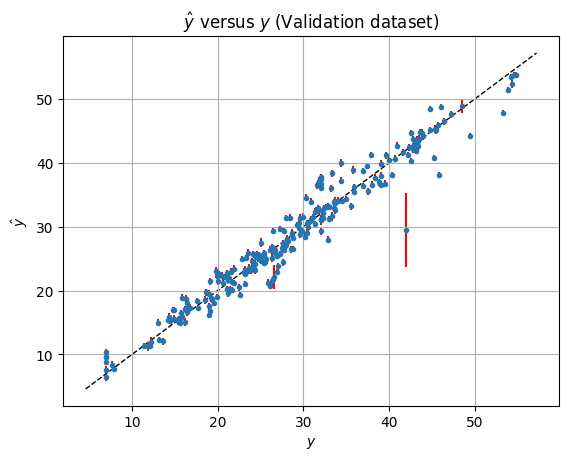

In [67]:
y_te_hat_norm = GPR_te['expected']
s2_hat_norm = GPR_te['variance']
# s2_hat = np.array([s2_hat_norm[i] * (y_te[i] - y_te_hat[i]) / (y_te_norm[i] - y_te_hat_norm[i]) for i in range(Nte)])
s2_hat = s2_hat_norm * sy
plt.figure()
plt.plot(y_te, y_te_hat, '.', zorder=2)
plt.errorbar(y_te, y_te_hat, ecolor='r', fmt='none', yerr=2 * np.sqrt(s2_hat), zorder=1)
v = plt.axis()
plt.plot([v[0], v[1]], [v[0], v[1]], 'k--', linewidth=1, zorder=0)
plt.xlabel(r'$y$')
plt.ylabel(r'$\^y$')
plt.title('$\^y$ versus $y$ (Validation dataset)')
plt.grid()
plt.show()

Every point $(y_i, \^y_i)$ is associated to an error bar, which value is $2\sigma_i$.
The value of $2\sigma$ is computed by solving the following equation:
$\frac{y - \^y}{\sigma^2}=\frac{y_{norm} - \^y_{norm}}{\sigma_{norm}^2}$
which turns into
$\sigma^2=\sigma_0^2\sigma_{norm}^2$
and then $\sigma=\sqrt{\sigma^2}$